In [1]:
import jax.numpy as jnp
import jax.random as jr
from jax import jit

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tqdm.auto import trange

from ssm_jax.hmm.models import GaussianHMM

# Helper functions for plotting

In [2]:
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]
colors = sns.xkcd_palette(color_names)

def white_to_color_cmap(color, nsteps=256):
    """Return a cmap which ranges from white to the specified color.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    """
    # Get a red-white-black cmap
    cdict = {'red': ((0.0, 1.0, 1.0),
                       (1.0, color[0], color[0])),
                'green': ((0.0, 1.0, 1.0),
                          (1.0, color[1], color[0])),
                'blue': ((0.0, 1.0, 1.0),
                         (1.0, color[2], color[0]))}
    cmap = LinearSegmentedColormap('white_color_colormap', cdict, nsteps)
    return cmap


def gradient_cmap(colors, nsteps=256, bounds=None):
    """Return a colormap that interpolates between a set of colors.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = jnp.linspace(0,1,ncolors)


    reds = []
    greens = []
    blues = []
    alphas = []
    for b,c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap

cmap = gradient_cmap(colors)

# Construct an HMM with specific parameters

In [3]:
# Set dimensions
num_states = 5
emission_dim = 2

# Specify parameters of the HMM
initial_probs = jnp.ones(num_states) / num_states
transition_matrix = 0.95 * jnp.eye(num_states) + 0.05 * jnp.roll(jnp.eye(num_states), 1, axis=1)
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, num_states+1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, num_states+1))[:-1]
])
emission_covs = jnp.tile(0.1**2 * jnp.eye(emission_dim), (num_states, 1, 1))

# Make a true HMM
true_hmm = GaussianHMM(initial_probs,
                       transition_matrix,
                       emission_means, 
                       emission_covs)

# Sample states and emissions from the HMM

In [4]:
num_timesteps = 2000
states, emissions = true_hmm.sample(jr.PRNGKey(0), num_timesteps)

# Show the emission probabilities

Text(0.5, 1.0, 'Emission Distributions')

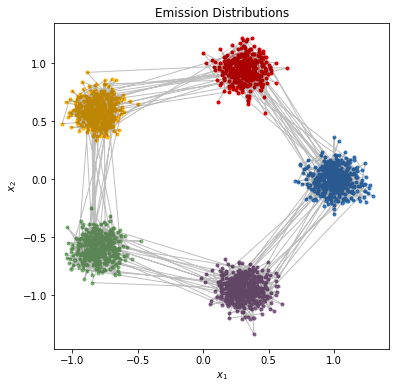

In [5]:
lim = .85 * abs(emissions).max()
XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), 
                      jnp.linspace(-lim, lim, 100))
grid = jnp.column_stack((XX.ravel(), YY.ravel()))

lls = true_hmm.emission_distribution.log_prob(grid[:, None, :])
plt.figure(figsize=(6, 6))
for k in range(num_states):
    plt.contour(XX, YY, jnp.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(emissions[states==k, 0], 
             emissions[states==k, 1], 
             'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(emissions[:,0], emissions[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Emission Distributions")

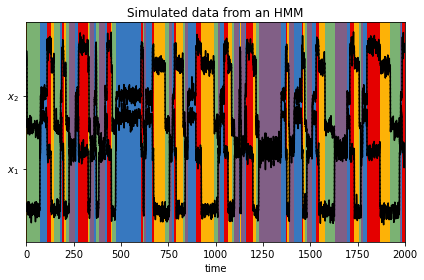

In [6]:
# Plot the data and the smoothed data
lim = 1.05 * abs(emissions).max()
plt.imshow(states[None,:],
           aspect="auto",
           interpolation="none",
           cmap=cmap,
           vmin=0, vmax=len(colors)-1,
           extent=(0, num_timesteps, -lim, (emission_dim)*lim),
           alpha=1)

means = true_hmm.emission_means[states]
for d in range(emission_dim):
    plt.plot(emissions[:,d] + lim * d, '-k')
    plt.plot(means[:,d] + lim * d, ':k')

plt.xlim(0, num_timesteps)
plt.xlabel("time")
plt.yticks(lim * jnp.arange(emission_dim), ["$x_{}$".format(d+1) for d in range(emission_dim)])

plt.title("Simulated data from an HMM")
plt.tight_layout()

In [7]:
print("log joint prob:    ", true_hmm.log_prob(states, emissions))
print("log marginal prob: ", true_hmm.marginal_log_prob(emissions))

log joint prob:     3149.1013
log marginal prob:  3149.1047


# Make sure we can jit functions that operate on HMMs

In [8]:
@jit
def identity(x):
    return x
identity(true_hmm)

# Fit an HMM to the simulated data with EM

In [9]:
from ssm_jax.hmm.core import hmm_smoother
from tensorflow_probability.substrates.jax.distributions import (
    Dirichlet, 
    Categorical, 
    MultivariateNormalFullCovariance as MVN
)

# Specify parameters of the HMM
test_hmm = GaussianHMM.random_initialization(jr.PRNGKey(1), 2 * num_states, emission_dim)

# Define the EM steps
def e_step(hmm, emissions):
    return hmm_smoother(hmm.initial_probabilities,
                        hmm.transition_matrix,
                        hmm.emission_distribution.log_prob(emissions[..., None, :]))

def m_step(emissions, posterior):
    # Initial distribution
    initial_probs = Dirichlet(
        1.0001 + posterior.smoothed_probs[0]).mode()

    # Transition distribution
    transition_matrix = Dirichlet(
        1.0001 + jnp.einsum('tij->ij', posterior.smoothed_transition_probs)).mode()

    # Gaussian emission distribution
    w_sum = jnp.einsum('tk->k', posterior.smoothed_probs)
    x_sum = jnp.einsum('tk, ti->ki', posterior.smoothed_probs, emissions)
    xxT_sum = jnp.einsum('tk, ti, tj->kij', posterior.smoothed_probs, emissions, emissions)

    emission_means = x_sum / w_sum[:, None]
    emission_covs = xxT_sum / w_sum[:, None, None] \
        - jnp.einsum('ki,kj->kij', emission_means, emission_means) \
        + 1e-4 * jnp.eye(emissions.shape[1])
    
    # Pack the results into a new GaussianHMM
    return GaussianHMM(initial_probs,
                       transition_matrix,
                       emission_means,
                       emission_covs)

@jit
def em_step(hmm):
    print("jitting")
    posterior = e_step(hmm, emissions)
    hmm = m_step(emissions, posterior)
    return hmm, posterior


# Run the EM iterations
log_probs = []
for _ in trange(50):
    test_hmm, posterior = em_step(test_hmm)
    log_probs.append(posterior.marginal_log_lkhd)

  0%|          | 0/50 [00:00<?, ?it/s]

jitting


# Plot the log probabilities over EM iterations

Text(0, 0.5, 'Marginal log likelihood')

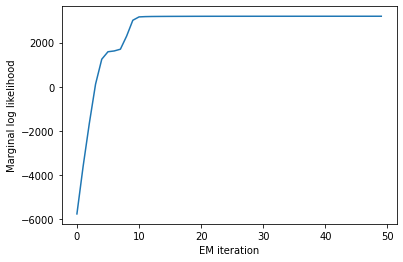

In [10]:
plt.plot(log_probs)
plt.xlabel("EM iteration")
plt.ylabel("Marginal log likelihood")

In [11]:
print("true LL: ", true_hmm.marginal_log_prob(emissions))
print("inf LL:  ", test_hmm.marginal_log_prob(emissions))

true LL:  3149.1047
inf LL:   3187.9805


# Plot the true and inferred states

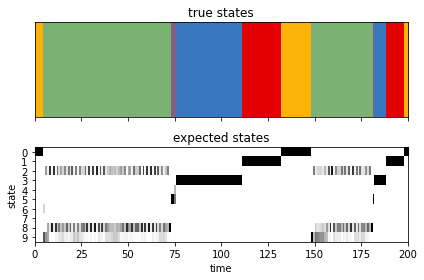

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].imshow(states[None,:],
              aspect="auto",
              interpolation="none",
              cmap=cmap, 
              vmin=0, vmax=len(colors)-1,
              alpha=1)
axs[0].set_yticks([])
axs[0].set_title("true states")

axs[1].imshow(posterior.smoothed_probs.T,
              aspect="auto",
              interpolation="none",
              cmap="Greys",
              vmin=0, vmax=1)
axs[1].set_yticks(jnp.arange(test_hmm.num_states))
axs[1].set_ylabel("state")
axs[1].set_xlabel("time")
axs[1].set_title("expected states")

plt.xlim(0, 200)
plt.tight_layout()
